# Partie Thermique

---

In [31]:
#Initialisation des constante

lbda = 0.96
rho = 2550
Cp = 840

N = 1000
R = 1

t = 1
Nt = 1000

Text = [273]*(Nt)
Tref = 300

In [32]:
#Calcule des constantes
W = 2*lbda/(rho * Cp)
dr = R / N
dt = t / Nt

T = []

#Text.insert(0, Tref)

#Initialisation de la temperaure
for i in range(Nt):
    T.append(( ([Tref]*(N+0)) + [Text[i]] ))

In [33]:
'''
c1 = []
Tprec=Text[0]

for i in range(N, -1, -1):
    print(Tprec)
    ca = dr * i * (Tprec - T[0][i]) / (W*dt)
    da = Tprec - ca * dr * i
    T[1][i] = ca * dr * i + da
    Tprec = ca * dr * (i-1) + da
    c1.append(ca)

for m in range(2, Nt):
    Tprec = Text[m]

    for i in range(N, -1, -1):
        ca = dr * i * (Tprec - T[m-1][i]) / (W*dt) * (-1 if i == N else 1)
        da = Tprec - dr * i * (c1[i] if i != N else ca)
        T[m][i] = ca * dr * i + da
        Tprec = ca * dr * (i-1) + da
'''

'\nc1 = []\nTprec=Text[0]\n\nfor i in range(N, -1, -1):\n    print(Tprec)\n    ca = dr * i * (Tprec - T[0][i]) / (W*dt)\n    da = Tprec - ca * dr * i\n    T[1][i] = ca * dr * i + da\n    Tprec = ca * dr * (i-1) + da\n    c1.append(ca)\n\nfor m in range(2, Nt):\n    Tprec = Text[m]\n\n    for i in range(N, -1, -1):\n        ca = dr * i * (Tprec - T[m-1][i]) / (W*dt) * (-1 if i == N else 1)\n        da = Tprec - dr * i * (c1[i] if i != N else ca)\n        T[m][i] = ca * dr * i + da\n        Tprec = ca * dr * (i-1) + da\n'

In [34]:
for m in range(Nt):
    for i in range(N):
        T[m][i] = W * dt * ( (T[m-1][i+1] - 2*T[m-1][i] + T[m-1][i-1])/(dr*dr) + 4*(T[m-1][i+1] - T[m-1][i]) / ( dr * dr * (2*i + 1))) + T[m-1][i]

In [35]:
Tim = [ [ (T[m][i] + T[m][i-1])/2 for i in range(1, N+0)] for m in range(0, Nt)]
DTim = [ [Tref - Tim[m][i] for i in range(len(Tim[0]))] for m in range(len(Tim))]

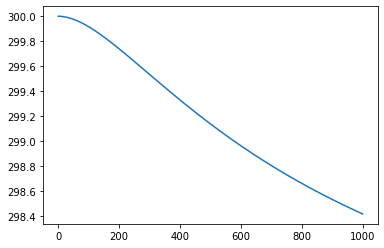

In [36]:
from matplotlib import pyplot as plt

a = [ T[i][1] for i in range(len(T))]
plt.plot(range(Nt), a)

In [37]:
print(T)

0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300

# Partie Mécanique

---